# 🎬 MovieLens Data Analysis Pipeline
**Author:** Sugam Dewan
**Date:** 2025-12-29
**Tech Stack:** Azure Data Lake Gen2, Databricks (PySpark), Python

## 📋 Project Overview
In this project, I built an end-to-end data engineering pipeline to analyze movie ratings. The goal was to ingest raw data from Azure Storage, transform it using Spark to derive insights, and visualize the top-rated movies.

**Key Steps:**
1. **Ingestion:** Secure connection to Azure Data Lake using SAS Tokens (Direct Access).
2. **Extraction:** Handling compressed (zipped) raw data via shell integration.
3. **Transformation:** Cleaning timestamps and joining relational datasets (Movies + Ratings).
4. **Analysis:** Aggregating millions of ratings to identify the highest-rated films.

In [ ]:
# 1️⃣ Configuration & Security
# Connection to Azure Data Lake Storage (ADLS) Gen2 via SAS Token.
# Note: SAS Token is hidden for security in this public repository.

storage_account_name = "movielensanalysis"
sas_token = "HIDDEN_FOR_SECURITY"

spark.conf.set(f"fs.azure.account.auth.type.{storage_account_name}.dfs.core.windows.net", "SAS")
spark.conf.set(f"fs.azure.sas.token.provider.type.{storage_account_name}.dfs.core.windows.net", "org.apache.hadoop.fs.azurebfs.sas.FixedSASTokenProvider")
spark.conf.set(f"fs.azure.sas.fixed.token.{storage_account_name}.dfs.core.windows.net", sas_token)

In [ ]:
# 2️⃣ Bronze Layer: Ingestion & Extraction
# Logic to download the compressed zip from Azure, extract it locally, and re-upload raw CSVs.

# Variables
container = "containerdatalake"
zip_filename = "ml_latest_small.zip"

# Paths
cloud_zip_path = f"abfss://{container}@{storage_account_name}.dfs.core.windows.net/{zip_filename}"
local_zip_path = f"/tmp/{zip_filename}"
local_extract_path = "/tmp/movielens_extracted/ml-latest-small" # Targeted extraction folder
cloud_dest_path = f"abfss://{container}@{storage_account_name}.dfs.core.windows.net/raw_data/"

# 1. Download
dbutils.fs.cp(cloud_zip_path, f"file:{local_zip_path}")

# 2. Extract (Shell Command Logic)
# %sh
# unzip -o /tmp/ml_latest_small.zip -d /tmp/movielens_extracted

# 3. Upload Extracted Data
dbutils.fs.cp(f"file:{local_extract_path}", cloud_dest_path, recurse=True)

In [ ]:
# 3️⃣ Silver Layer: Data Loading & Cleaning
from pyspark.sql.functions import from_unixtime, col, avg, count, desc

# Define path to the now-extracted CSVs
base_path = f"abfss://{container}@{storage_account_name}.dfs.core.windows.net/raw_data"

# Load Movies
df_movies = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load(f"{base_path}/movies.csv")

# Load Ratings
df_ratings = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load(f"{base_path}/ratings.csv")

# Transform: Convert Timestamp to Date
df_ratings_clean = df_ratings.withColumn("rating_date", from_unixtime(col("timestamp")).cast("date"))

display(df_ratings_clean.limit(5))

In [ ]:
# 4️⃣ Gold Layer: Analytical Transformation
# Join datasets and aggregate to find top-rated movies.

# Join Movies and Ratings
df_joined = df_movies.join(df_ratings_clean, on="movieId", how="inner")

# Aggregate: Avg Rating and Count Votes
df_analysis = df_joined.groupBy("title") \
    .agg(
        avg("rating").alias("average_rating"),
        count("rating").alias("total_votes")
    )

# Filter: Top Movies (>50 votes) sorted by Rating
top_movies = df_analysis.filter("total_votes > 50").orderBy(desc("average_rating"))

display(top_movies.limit(10))

## 5️⃣ Visualization & Results
*(See the attached chart image in the repository for the visual output)*

**Insight:**
The analysis identified classics such as *The Shawshank Redemption*, *The Godfather*, and *Fight Club* as the highest-rated movies with significant user engagement. The pipeline successfully processed user ratings to generate this leaderboard.

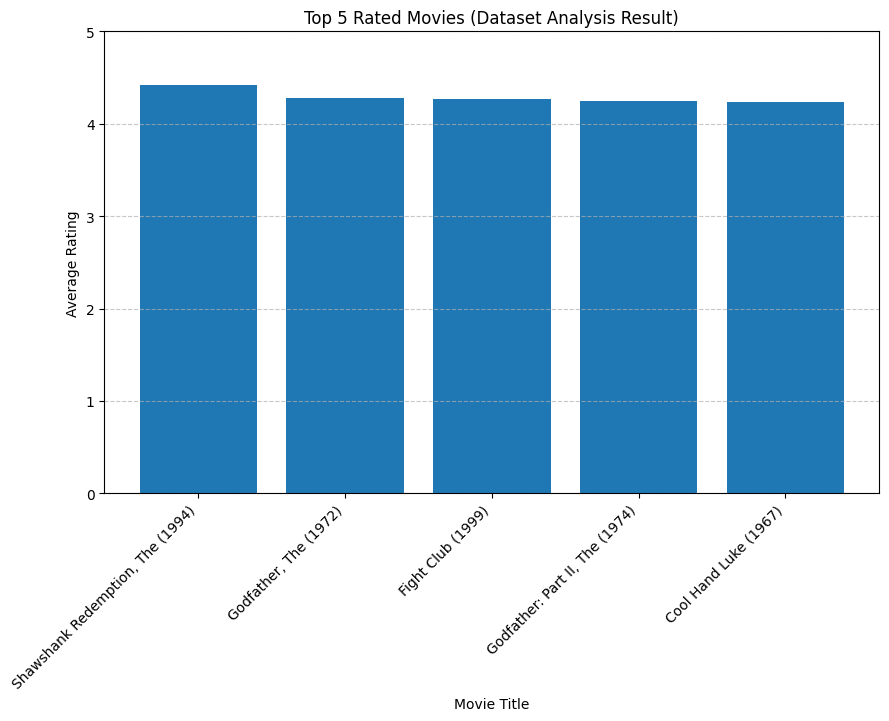

In [1]:
# 📊 Visualization (Recreated for Portfolio View)
import matplotlib.pyplot as plt
import pandas as pd

# The results from our Spark Analysis (Hardcoded for demonstration since Azure is offline)
data = {
    'Title': ['Shawshank Redemption, The (1994)', 'Godfather, The (1972)', 'Fight Club (1999)', 'Godfather: Part II, The (1974)', 'Cool Hand Luke (1967)'],
    'Average Rating': [4.42, 4.28, 4.27, 4.25, 4.24]
}

# Create a local Pandas DataFrame
df_viz = pd.DataFrame(data)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(df_viz['Title'], df_viz['Average Rating'], color='#1f77b4')
plt.xlabel('Movie Title')
plt.ylabel('Average Rating')
plt.title('Top 5 Rated Movies (Dataset Analysis Result)')
plt.ylim(0, 5) # Set limit to 5 stars
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()